# How to build a bandpass filter

> Reference: https://github.com/mravanelli/SincNet

In [1]:
import numpy as np
import math
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchaudio
import matplotlib.pyplot as plt

## Load a waveform

In [2]:
wav_file = '../piece_20_32k.wav'
waveform, samplerate = torchaudio.load(wav_file, normalization=True)
print(waveform.shape, samplerate)

torch.Size([1, 785077]) 32000


## Set the bound of frequency

In [3]:
min_band_hz = 50
min_hz = 50
max_hz = samplerate // 2 - (min_hz + min_band_hz)

print("Minimum band: {}\nMinimum frequency: {}\nMaximum frequency: {}".format(min_band_hz, min_hz, max_hz))

Minimum band: 50
Minimum frequency: 50
Maximum frequency: 15900


## Create several pass band based on mel

In [4]:
def hz2mel(hz):
    return 2595 * np.log10(1 + hz / 700.)

def mel2hz(mel):
    return 700 * (10 ** (mel / 2595.) - 1)

out_channels = 3
mel = np.linspace(hz2mel(min_hz),
                  hz2mel(max_hz),
                  num=out_channels+1)
hz = mel2hz(mel)

print('Mel:', list(mel.astype(int)))
print('Hz:', list(hz.astype(int)))

Mel: [77, 1241, 2404, 3568]
Hz: [49, 1405, 5212, 15900]


## Define a Hamming window

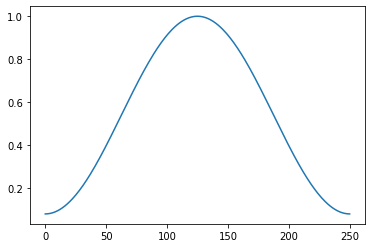

In [5]:
kernel_size = 251

n = np.linspace(0, kernel_size, kernel_size)
window = 0.54 - 0.46 * np.cos(2 * math.pi * n / kernel_size)

plt.plot(window)

## Build serveral bandpass filters and show them

$$g(n,f_1,f_2)=\left(\frac{\sin\left(2n\pi f_2\right)}{n\pi} - \frac{\sin\left(2n\pi f_1\right)}{n\pi}\right)\cdot\left(0.54-0.46\cos\left(\frac{2N\pi}{L}\right)\right)$$

$$n=\left[\frac{-L}{2\times\text{samplerate}},\frac{L}{2\times\text{samplerate}}\right]$$

$$N=\left[1,L\right]$$

Note that weights of filters must be normalized.

torch.Size([1, 251])
tensor([[   50.0000,  1355.7665,  1405.7665],
        [ 1405.7665,  3806.5701,  5212.3364],
        [ 5212.3364, 10687.6631, 15900.0000]])
tensor([[ 9018.3633],
        [15402.8135],
        [26034.2676]])
The shape of filters torch.Size([3, 1, 251])


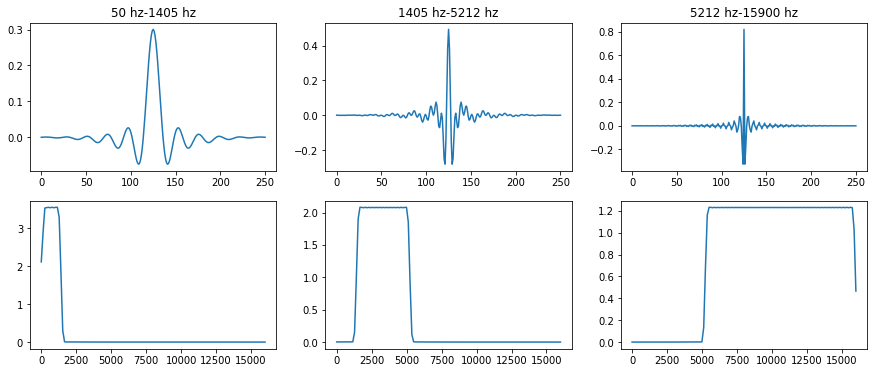

In [6]:
n = 2 * math.pi * torch.arange(-(kernel_size // 2), (kernel_size // 2) + 1).view(1, -1) / samplerate
n[n == 0] = 1e-8

low_hz = torch.Tensor(hz[:-1]).view(-1, 1)
band_hz = torch.Tensor(np.diff(hz)).view(-1, 1)
high_hz = torch.Tensor(hz[1:]).view(-1, 1)

print(n.shape)
print(torch.cat([low_hz, band_hz, high_hz], dim=1))

f_t_low = torch.matmul(low_hz, n)
f_t_high = torch.matmul(high_hz, n)

filters = ((torch.sin(f_t_high)-torch.sin(f_t_low))/(n/2))*torch.from_numpy(window).type(torch.float32)
filters[:,kernel_size//2:kernel_size//2+1] = 2. * (high_hz - low_hz)
print(torch.norm(filters, dim=1, keepdim=True))
filters = filters / torch.norm(filters, dim=1, keepdim=True)#filters / filters.max()#[:,125:126] # 权重归一化
filters = filters.view(out_channels, 1, kernel_size)

print("The shape of filters {}".format(filters.shape))

plt.figure(figsize=(15, 6))
for i in range(out_channels):
    plt.subplot(2,3,i+1)
    plt.plot(filters[i,0,:].detach().numpy())
    plt.title('%d hz-%d hz' % (low_hz[i,0], high_hz[i,0]))
    plt.subplot(2,3,i+1+3)
    plt.plot(np.linspace(0, samplerate//2, kernel_size//2+1), np.abs(np.fft.rfft(filters[i,0,:].detach().numpy())))

In [ ]:
torch.norm(filters.squeeze(), dim=1, keepdim=True)

## Compute the result after bandpass filtering by PyTorch `conv1d`

In [ ]:
wav = waveform[0,:10000].view(1,1,-1)[:,:,:3000]
out = F.conv1d(wav, filters, stride=1, padding=0)
print(out.shape)
plt.figure(figsize=(8, 3))
plt.plot(out[0].t())
plt.legend(['[%5d hz-%5dhz]' % (int(low), int(high)) for low, high in zip(low_hz[:,0].numpy(), 
                                                             high_hz[:,0].numpy())], 
           loc='best', ncol=1)
plt.title('Signal after filtering')
plt.figure(figsize=(8, 3))
plt.plot(wav[0,0])
plt.title('Original signal')

# Thanks for Attention

In [7]:
# Thanks for Attention

tensor([[1.0000],
        [1.0000],
        [1.0000]])

## Compute the result after bandpass filtering by PyTorch `conv1d`

torch.Size([1, 3, 2750])


Text(0.5, 1.0, 'Original signal')

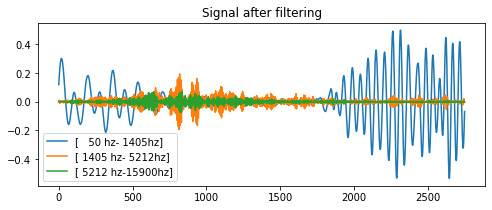

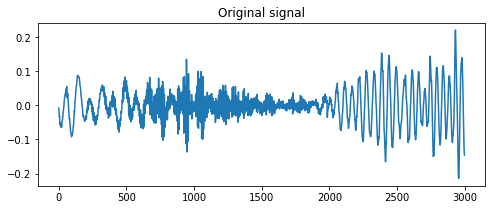

In [8]:
wav = waveform[0,:10000].view(1,1,-1)[:,:,:3000]
out = F.conv1d(wav, filters, stride=1, padding=0)
print(out.shape)
plt.figure(figsize=(8, 3))
plt.plot(out[0].t())
plt.legend(['[%5d hz-%5dhz]' % (int(low), int(high)) for low, high in zip(low_hz[:,0].numpy(), 
                                                             high_hz[:,0].numpy())], 
           loc='best', ncol=1)
plt.title('Signal after filtering')
plt.figure(figsize=(8, 3))
plt.plot(wav[0,0])
plt.title('Original signal')

# Thanks for Attention